In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import networkx as nx
import d3fdgraph
import pandas as pd

# 100 Prisoners Problem

## The problem

- 100 prisoners are given the chance to escape death row if they can win a game.
- Each prisoner is given a number from 1 to 100.
- There is a closed room with 100 boxes, each numbered 1 to 100.
- At the start of the game, each prisoner's number is randomly put into these 100 boxes.
- Each prisoner is given a turn to go inside the room and open 50 boxes to find his own number.
- Each prisoner is not allowed to communicate with other prisoners after his turn.
- The game is won if all prisoners are able to find their own number.

However, the prisoners are allowed to discuss a strategy before the game to maximize their chance of winning the game. What strategy should they use?

## Simulation

In [5]:
def simulate(strategy, boxes_count=100):
    boxes = [i for i in range(1, boxes_count+1)]
    random.shuffle(boxes)
    
    def open_box(state, max_tries):
        def op(i):
            if state['tries'] >= max_tries:
                return None
            b = boxes[i]
            state['tries'] += 1
            state['opened'].add(i)
            return b
        return op
    
    found = 0
    for prisoner in range(1, boxes_count+1):
        max_tries = boxes_count//2
        state = {'tries': 0, 'opened': set()}
        
        bi = strategy(prisoner, boxes_count, open_box(state, max_tries))
        if bi != None and boxes[bi] == prisoner and bi in state['opened']:
            found += 1
        else:
            return False
    
    return found == boxes_count

In [6]:
simulations = 10000

## Strategy 1: randomly open 50 boxes

Each prisoner randomly opens 50 boxes until he finds his number.

In [7]:
def open_randomly(prisoner, boxes_count, open_box):
    boxes = [i for i in range(boxes_count)]
    random.shuffle(boxes)
    
    for bi in boxes:
        b = open_box(bi)
        if b == prisoner:
            return bi
        if b is None:
            break
    
    return None

print('chance of winning = {0:.3f}%'.format(np.mean([simulate(open_randomly) for i in range(simulations)])*100.0))

chance of winning = 0.000%


Using this strategy, there should be 0 success during the simulation. This is because each prisoner has a 50% probability of finding his number. So the probability of winning the game is:

$$
0.5^{100} = 0.0000000000000000000000000000008
$$

## Strategy 2: the best strategy

Each prisoner follows this process:

 1. Open the box with his own number.
 2. Take note of the number inside that box.
 3. Open the box with the number found from step 2.
 4. Repeat steps 2 and 3 until he either finds his number, or ran out of boxes to open.

In [8]:
def best_strategy(prisoner, boxes_count, open_box):
    current = prisoner-1
    
    while True:
        b = open_box(current)
        if b is None:
            return None
        elif b == prisoner:
            return current
        else:
            current = b-1
    return None

print('chance of winning = {0:.3f}%'.format(np.mean([simulate(best_strategy) for i in range(simulations)])*100.0))

chance of winning = 31.490%


## Best strategy explained: cycles

The strategy above basically constructs cycles of numbers. For example, take the following list of numbers from 1 to 10 that is randomly shuffled:

In [41]:
numbers = [i for i in range(1, 11)]
random.shuffle(numbers)
numbers

[2, 10, 4, 8, 1, 7, 5, 9, 3, 6]

If you follow the strategy above, you will get the following cycles of numbers:

In [45]:
# rotates a ring such that it starts with the smallest number in that ring
def rotate_ring(ring):
    rotated = ring.copy()
    front = min(rotated)
    while rotated[0] != front:
        rotated.insert(0, rotated.pop())
    return rotated

def find_rings(numbers):
    rings = {}
    
    for i in range(len(numbers)):
        ring = [numbers[i]]
        current = numbers[i]-1
        while numbers[current] != ring[0]:
            ring.append(numbers[current])
            current = numbers[current]-1
            
        ring = rotate_ring(ring)
        if ring[0] in rings and rings[ring[0]] != ring:
            print('impossible!')
        rings[ring[0]] = ring
        
    return list(rings.values())

def generate_rings(count=100):
    numbers = [i for i in range(1, count+1)]
    random.shuffle(numbers)
    return find_rings(numbers)

In [46]:
rings = find_rings(numbers)
rings

[[1, 2, 10, 6, 7, 5], [3, 4, 8, 9]]

It's easier to see this visualized:

In [53]:
def get_cmap(n, name='hsv'):
    return list(map(rgb2hex, plt.cm.get_cmap(name, n).colors))

def plot_rings(rings, count=100, node_size=700, figsize=(25,25)):
    G = nx.Graph()
    G.add_nodes_from(range(1, count+1))

    cmap = get_cmap(len(rings), 'tab20')

    for j in range(len(rings)):
        ring = rings[j]
        for i in range(len(ring)):
            G.add_edge(ring[i], ring[(i+1)%len(ring)])

    node_colors = []
    for n in G.nodes:
        for j in range(len(rings)):
            if n in rings[j]:
                node_colors.append(cmap[j])
                break

    edge_colors = []
    for u, v in G.edges:
        for j in range(len(rings)):
            if u in rings[j]:
                edge_colors.append(cmap[j])
                break

    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(G, ax=ax, node_color=node_colors, edge_color=edge_colors, pos=nx.circular_layout(G),
            with_labels=True, node_size=node_size, width=3, font_color='white', font_weight='bold')

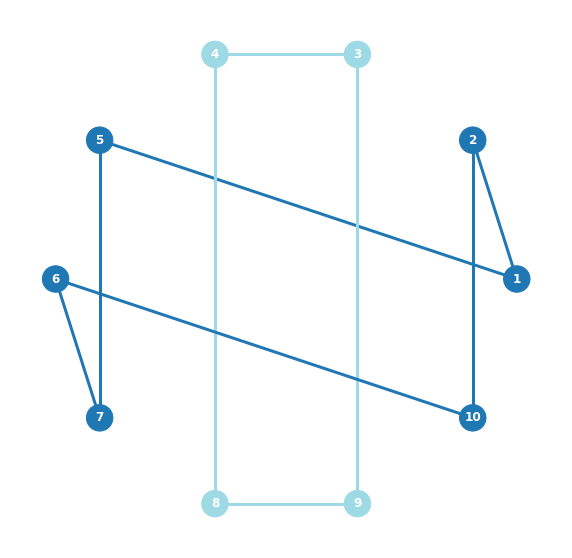

In [54]:
plot_rings(rings, count=10, figsize=(10,10))

Interactive visualization:

In [55]:
def plot_rings_interactive(rings, count=100):
    G = nx.Graph()
    G.add_nodes_from(range(1, count+1))
    for j in range(len(rings)):
        ring = rings[j]
        for i in range(len(ring)):
            G.add_edge(ring[i], ring[(i+1)%len(ring)])
    df = pandas.DataFrame([{'source': str(u), 'target': str(v), 'weight': 1} for u, v in G.edges])
    d3fdgraph.plot_force_directed_graph(df, node_radius=5, link_distance=0.1, collision_scale=1)
    
plot_rings_interactive(rings, count=10)

force-directed graph

Now just scale it up to 100 numbers:

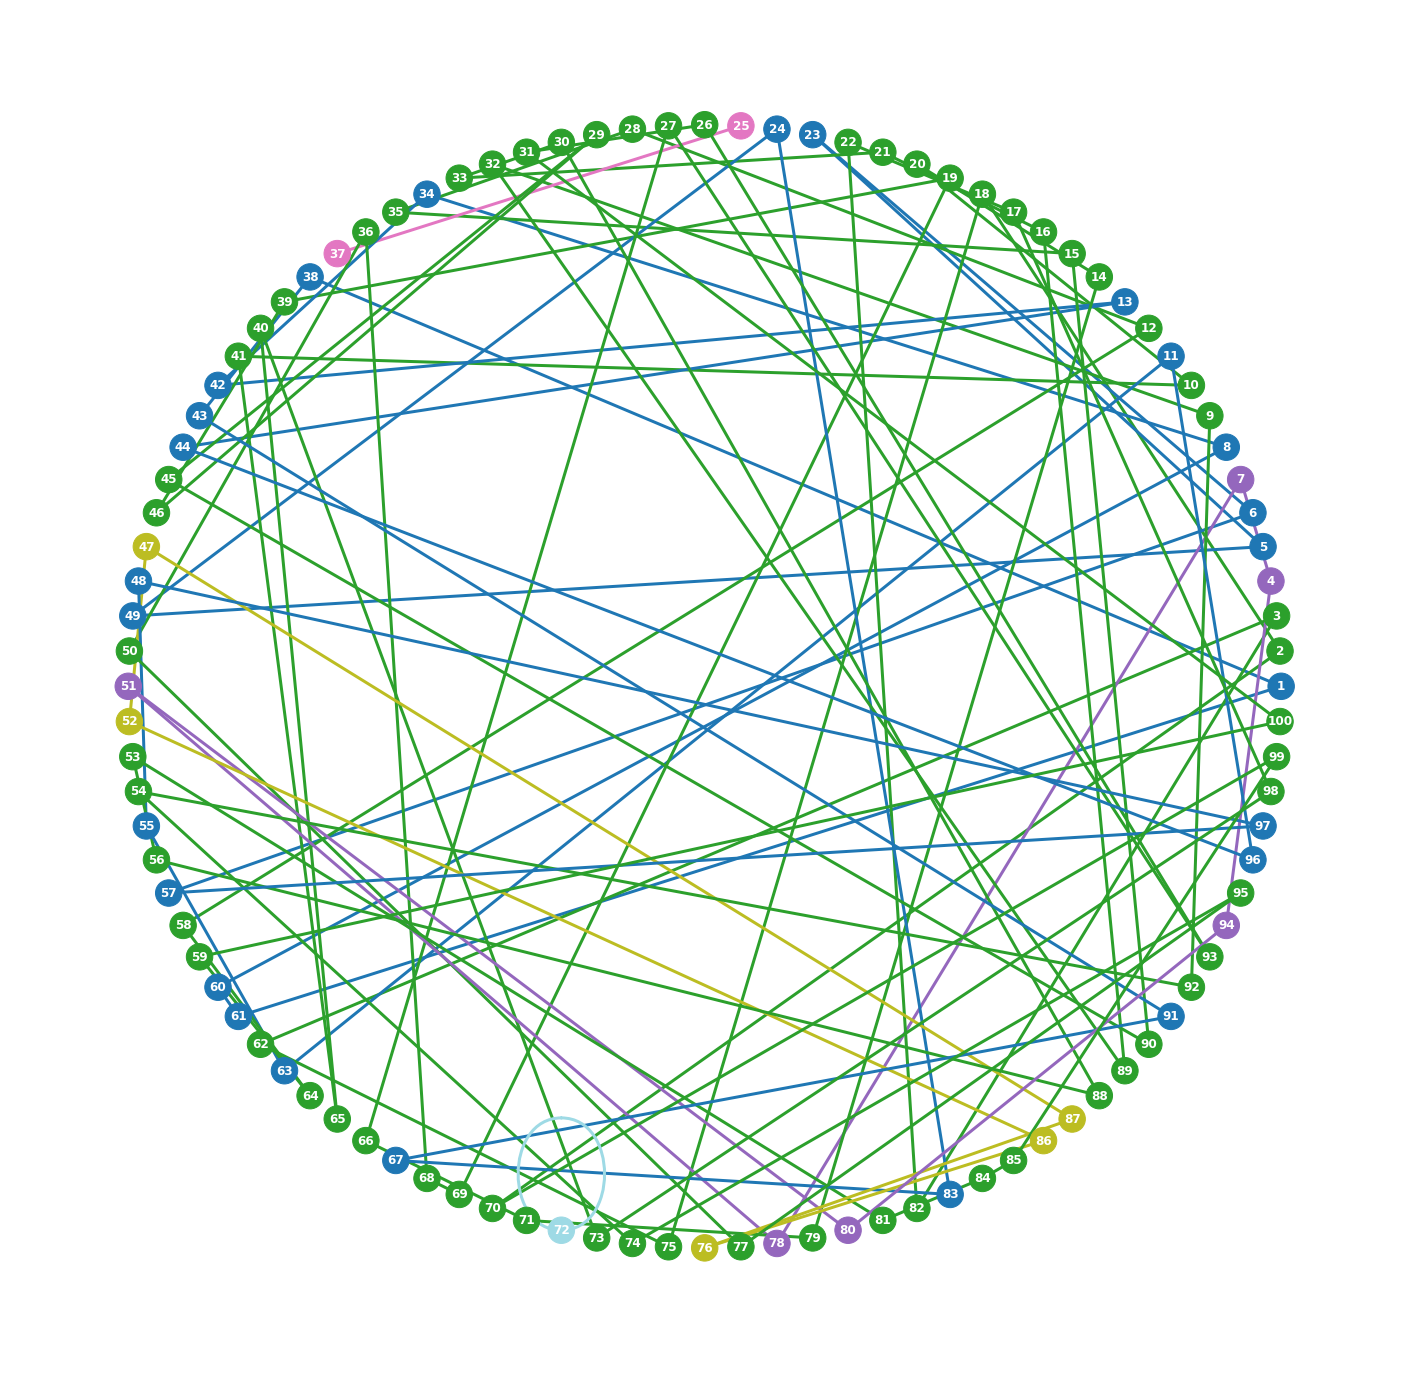

In [56]:
rings = generate_rings()
plot_rings(rings)

In [57]:
plot_rings_interactive(rings)

force-directed graph

### What's the significance of cycles?

Since the permutation of numbers are simply cycles of numbers, when a prisoner looks for his number,
he will find his number on one of these cycles. **The number of tries it will take him to find his number equals the size of the cycle.**

For example, let's say there is a cycle of the following numbers:

> 52, 86, 76, 87, 47

Let's say the prisoner's number is 87. The following will happen:
- He opens box 87 to find 47
- He opens box 47 to find 52
- He opens box 52 to find 86
- He opens box 86 to find 76
- He opens box 76 to find 87

Since to win the game requires all prisoners to find their number in at most 50 moves, **this means that the prisoners are guaranteed to win the game if the largest cycle has at most 50 numbers**. Conversely, the prisoners are guaranteed to lose if the largest cycle has more than 50 numbers.

So the probabilty of winning the game using the strategy is simply the probability of having the largest cycle of 50 numbers or less.

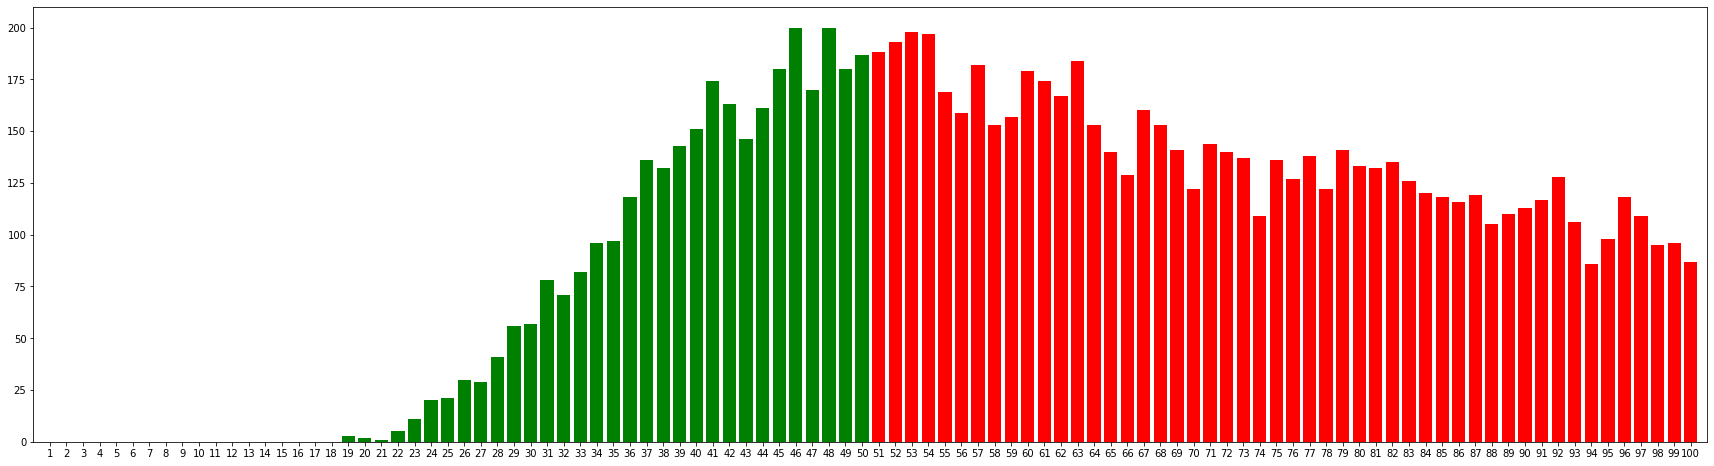

In [59]:
longest_ring_sizes = []
for i in range(10000):
    longest_ring_sizes.append(max(list(map(len, generate_rings()))))
    
counts = np.bincount(longest_ring_sizes)[1:]
colors = ['green' if i < 50 else 'red' for i in range(100)]

fig, ax = plt.subplots(figsize=(30, 8))
xmax = 100
ax.bar(range(1, 101), counts, width=0.8, align='center', color=colors)
ax.set(xticks=range(1, 101), xlim=[0, 101]);

In [60]:
sum(counts[:50])/sum(counts)

0.3141

## What happens if there are more prisoners?

The probability remains the same even with more prisoners, since the distribution of largest cycle remains the same.

In [61]:
print('chance of winning = {0:.3f}%'.format(np.mean([simulate(best_strategy, boxes_count=200) for i in range(simulations)])*100.0))

chance of winning = 30.960%


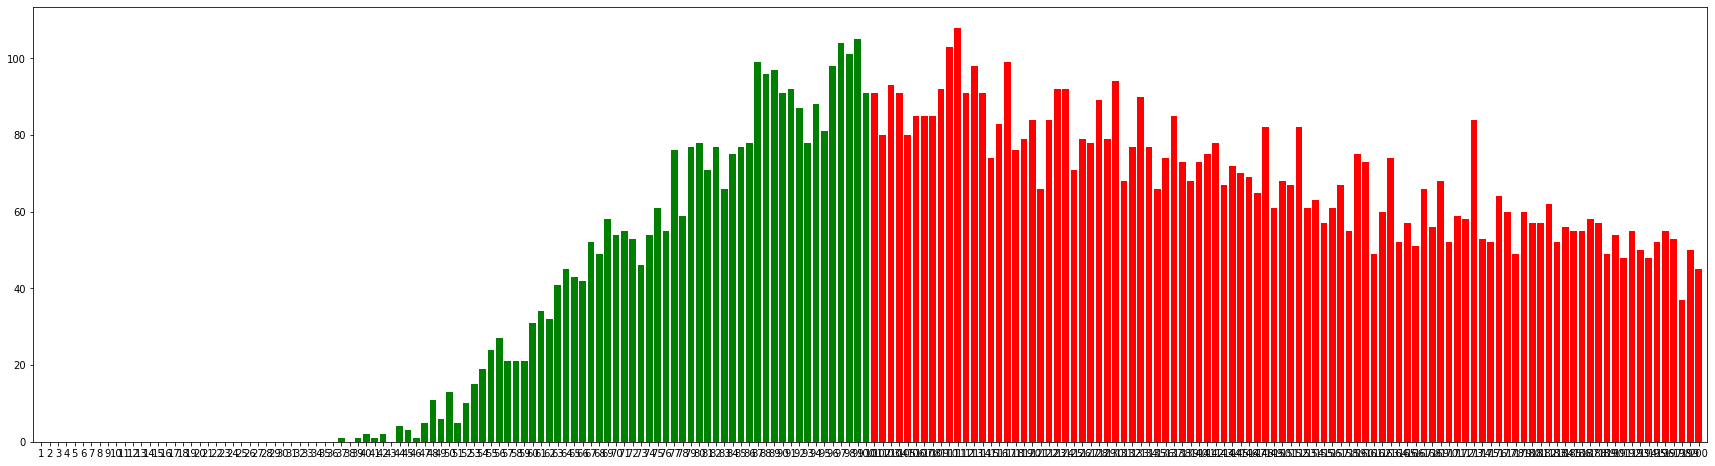

In [67]:
longest_ring_sizes = []
for i in range(10000):
    longest_ring_sizes.append(max(list(map(len, generate_rings(200)))))
    
counts = np.bincount(longest_ring_sizes)[1:]
colors = ['green' if i < 100 else 'red' for i in range(200)]

fig, ax = plt.subplots(figsize=(30, 8))
xmax = 200
ax.bar(range(1, 201), counts, width=0.8, align='center', color=colors)
ax.set(xticks=range(1, 201), xlim=[0, 201]);

In [69]:
sum(counts[:100])/sum(counts)

0.306